### Notebook to test out vortex tracking from WRF TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
June 2022

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
from matplotlib import ticker, cm
import matplotlib.pyplot as plt
import sys
import cartopy
# import cmocean
# from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
# from stratiform_index import stratiform_index

#### Directories

In [2]:
figdir = "/Users/jruppert/code/tc_figs/"

# main = "/Users/jamesruppert/code/tc_output/"
main = "/Users/jruppert/code/tc_output/"
storm = !ls $main
# print(storm)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[1]
# print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/ctl/'
print(datdir)

/Users/jruppert/code/tc_output/haiyan/memb_01/ctl/


#### Read variables

In [3]:
# LonLat
fil = Dataset(datdir+'../../LATLON.nc') # this opens the netcdf file
lon = fil.variables['XLONG'][:] # deg
lon1d=lon[0,:]
lat = fil.variables['XLAT'][:] # deg
lat1d=lat[:,0]
fil.close()
llshape=np.shape(lon)
nx = llshape[1]
ny = llshape[0]

# Pressure
fil = Dataset(datdir+'U.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
fil.close()
# nz = np.shape(pres)[0]

In [4]:
# Level selection
ptrack=400 # tracking pressure level
ikread = np.where(pres == ptrack)[0][0]
print('Tracking at:',round(pres[ikread]),'hPa')

Tracking at: 400 hPa


In [5]:
# Horizontal wind
ufil = Dataset(datdir+'U.nc') # this opens the netcdf file
u = ufil.variables['U'][:,ikread,:,:] # m/s
ufil.close()
vfil = Dataset(datdir+'V.nc') # this opens the netcdf file
v = vfil.variables['V'][:,ikread,:,:] # m/s
vfil.close()

nt=np.shape(u)[0]

#### Calculate relative vorticity

$\zeta=\hat k \cdot \nabla \times \vec{U} = \dfrac{\partial v}{\partial x} - \dfrac{\partial u}{\partial y}$

For spherical: $\dfrac{\partial}{\partial y} \rightarrow \dfrac{\partial}{a\partial \Phi}$ and $\dfrac{\partial}{ \partial x} \rightarrow \dfrac{\partial}{a \text{cos}(\Phi) \partial \lambda}$, where $\lambda$ is longitude, $a$ is Earth radius, and $\Phi$ is latitude.

In [6]:
np.shape(v)

(169, 740, 1400)

In [7]:
a = 6371e3 # Earth radius, m
inva = 1./a
inv_cos = 1./np.cos(np.radians(lat1d))

dudy = np.gradient(u,lat1d,axis=1) * inva
dvdx = np.gradient(v,lon1d,axis=2) * inv_cos[np.newaxis,:,np.newaxis] * inva

# print("Shape of gradient variable:",np.shape(dvdx))
vor = (dvdx - dudy)

#### Conduct tracking

In [8]:
# Three-dimensional variables


---
### Plotting routines

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

#### Wind Speed

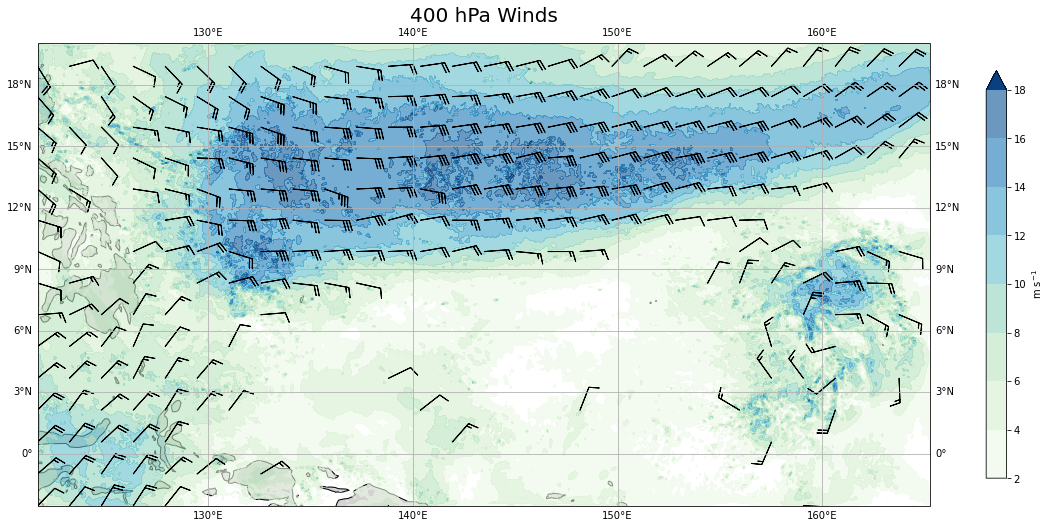

In [13]:
# select plotting area
plt_area=[-120, -50, 10, 70] # W,E,S,N
# plt_area=[-95, -55, 20, 55] # W,E,S,N

tsel=48
iu = u[tsel,:,:]
iv = v[tsel,:,:]
pltvar=np.sqrt(iu**2 + iv**2)

# create figure
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(str(round(pres[ikread])) + ' hPa Winds', fontsize=20)

# fill contour
clevs = np.arange(2, 20, 2)
im = ax.contourf(lon, lat, pltvar, clevs, cmap='GnBu', alpha=0.6,
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
cbar.ax.set_ylabel('m s$^{-1}$')
        # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

# wind barbs
spacing=50 #barbspacing (smaller if zoomed in)
mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
uplt = iu * mps_to_kts
vplt = iv * mps_to_kts
# mask for speeds < 10 kts
spd = np.sqrt(uplt**2+vplt**2)
uplt=np.ma.masked_where(spd < 10, uplt, copy=False)

ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
         uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
# ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
# ax.set_extent(plt_area)

plt.show()

#### Vorticity

In [11]:
print(np.max(vor))
print(np.min(vor))

0.00013254597
-8.105379e-05


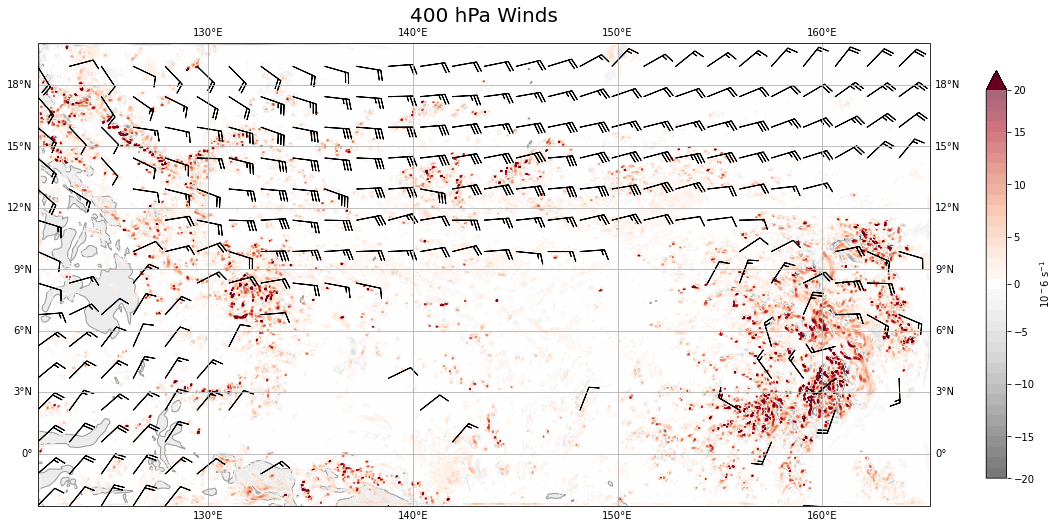

In [14]:
# select plotting area
plt_area=[-120, -50, 10, 70] # W,E,S,N
# plt_area=[-95, -55, 20, 55] # W,E,S,N

tsel=48
iu = u[tsel,:,:]
iv = v[tsel,:,:]
pltvar=vor[tsel,:,:]*1e6

# create figure
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
ax.set_title(str(round(pres[ikread])) + ' hPa Winds', fontsize=20)

# fill contour
clevsi = np.arange(1, 20, 1)
clevs = np.concatenate((-1*np.flip(clevsi),clevsi))
im = ax.contourf(lon, lat, pltvar, clevs, cmap='RdGy_r', alpha=0.6, \
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
cbar.ax.set_ylabel('$10^-6$ s$^{-1}$')
        # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

# wind barbs
spacing=50 #barbspacing (smaller if zoomed in)
mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
uplt = iu * mps_to_kts
vplt = iv * mps_to_kts
# mask for speeds < 10 kts
spd = np.sqrt(uplt**2+vplt**2)
uplt=np.ma.masked_where(spd < 10, uplt, copy=False)

ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
         uplt[::spacing,::spacing], vplt[::spacing,::spacing], zorder=2)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
# ax.add_feature(cartopy.feature.STATES)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Zoom into selected area (comment this out to plot entire available area)
# ax.set_extent(plt_area)

plt.show()